In [7]:
# given a capture file and LLM IP address, plot packet timings for packets to/from the LLM
capture_file = "../captures/capture_20251118_105743_172.64.155.209_32.txt"
llm_ip = "172.25.176.249"

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
import numpy as np
# read the capture file into a pandas dataframe
data = []
with open(capture_file, "r") as f:
    prev_line = None
    for line in f:
        # example line:
        # "    172.25.176.249.61872 > 172.64.155.209.443: Flags [.], seq 1727814583:1727815957, ack 2590525716, win 2757, options [nop,nop,TS val 1117289263 ecr 1369777364], length 1374\n"
        regex = re.compile(
            r"^\s*"
            r"(\d+\.\d+\.\d+\.\d+)\.\d+\s*>\s*"     # (1) src_ip
            r"(\d+\.\d+\.\d+\.\d+)\.\d+:"           # (2) dst_ip
            r"\s*Flags\s*\[([^\]]+)\],\s*"          # (3) flags
            r"seq\s+(\d+):(\d+),\s*"                # (4)(5) seq_start, seq_end
            r"ack\s+(\d+),\s*"                      # (6) ack
            r"win\s+(\d+),.*?"                      # (7) win
            r"length\s+(\d+)"                       # (8) length
        )
        match = regex.search(line)
        if match:

            # timestamp is first word on previous line
            timestamp = prev_line.split()[0]
            timestamp = datetime.strptime(timestamp, "%H:%M:%S.%f").timestamp()

            src_ip = match.group(1)
            dst_ip = match.group(2)
            flags = match.group(3)
            seq_start = int(match.group(4))
            seq_end = int(match.group(5))
            ack = int(match.group(6))
            win = int(match.group(7))
            length = int(match.group(8))
            data.append({
                "timestamp": timestamp,
                "src_ip": src_ip,
                "dst_ip": dst_ip,
                "flags": flags,
                "seq_start": seq_start,
                "seq_end": seq_end,
                "ack": ack,
                "win": win,
                "length": length
            })

        prev_line = line

df = pd.DataFrame(data)
print(df.head())
# filter for packets to/from the LLM IP
llm_df = df[(df['src_ip'] == llm_ip) | (df['dst_ip'] == llm_ip)].copy()
# sort by timestamp
llm_df = llm_df.sort_values(by='timestamp').reset_index(drop=True)
# compute time delta between packets
llm_df['time_delta'] = llm_df['timestamp'].diff().fillna(0)
# compute cumulative time
llm_df['cumulative_time'] = llm_df['time_delta'].cumsum()
print(llm_df.head())


      timestamp          src_ip          dst_ip flags   seq_start     seq_end  \
0 -2.208931e+09  172.25.176.249  172.64.155.209     .  1727814583  1727815957   
1 -2.208931e+09  172.25.176.249  172.64.155.209     .        1374        2748   
2 -2.208931e+09  172.25.176.249  172.64.155.209     .        2748        4122   
3 -2.208931e+09  172.25.176.249  172.64.155.209     .        4122        5496   
4 -2.208931e+09  172.25.176.249  172.64.155.209     .        5496        6870   

          ack   win  length  
0  2590525716  2757    1374  
1           1  2757    1374  
2           1  2757    1374  
3           1  2757    1374  
4           1  2757    1374  
      timestamp          src_ip          dst_ip flags   seq_start     seq_end  \
0 -2.208931e+09  172.25.176.249  172.64.155.209     .  1727814583  1727815957   
1 -2.208931e+09  172.25.176.249  172.64.155.209     .        1374        2748   
2 -2.208931e+09  172.25.176.249  172.64.155.209     .        2748        4122   
3 -2.2089

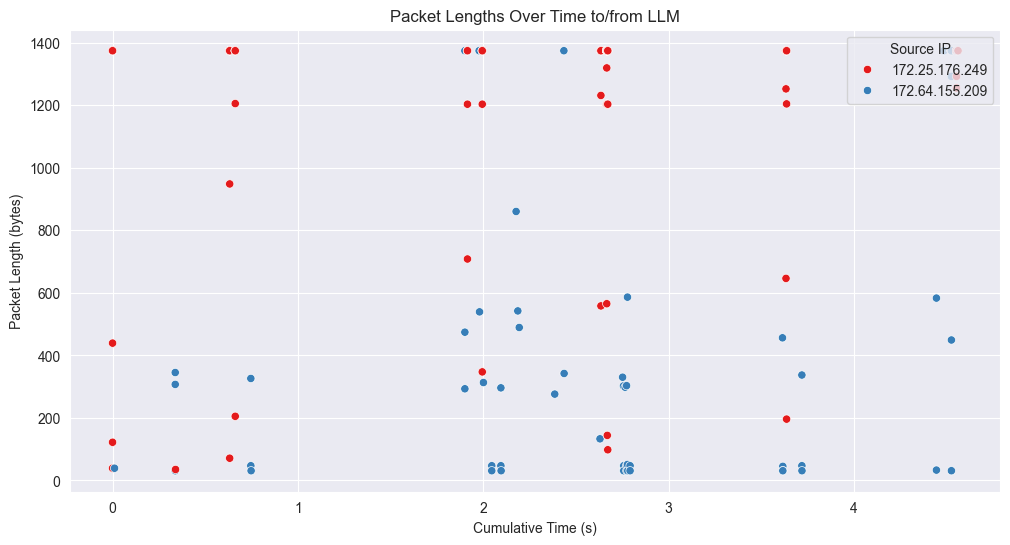

In [8]:
# plot packet lengths over time
plt.figure(figsize=(12, 6))
sns.scatterplot(data=llm_df, x='cumulative_time', y='length', hue='src_ip', palette='Set1')
plt.title('Packet Lengths Over Time to/from LLM')
plt.xlabel('Cumulative Time (s)')
plt.ylabel('Packet Length (bytes)')
plt.legend(title='Source IP', loc='upper right')
plt.grid(True)
plt.show()

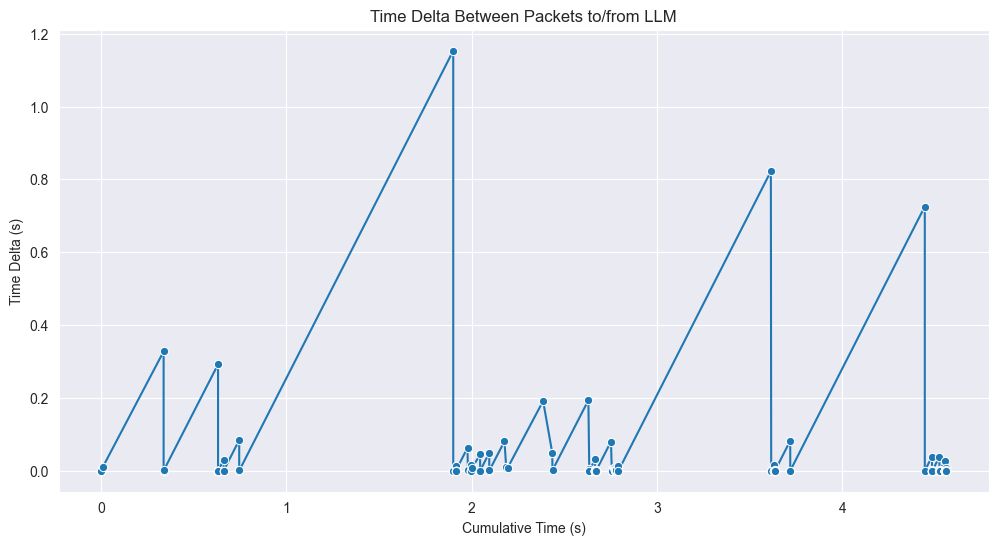

In [9]:
# plot time delta between packets
plt.figure(figsize=(12, 6))
sns.lineplot(data=llm_df, x='cumulative_time', y='time_delta', marker='o')
plt.title('Time Delta Between Packets to/from LLM')
plt.xlabel('Cumulative Time (s)')
plt.ylabel('Time Delta (s)')
plt.grid(True)
plt.show()

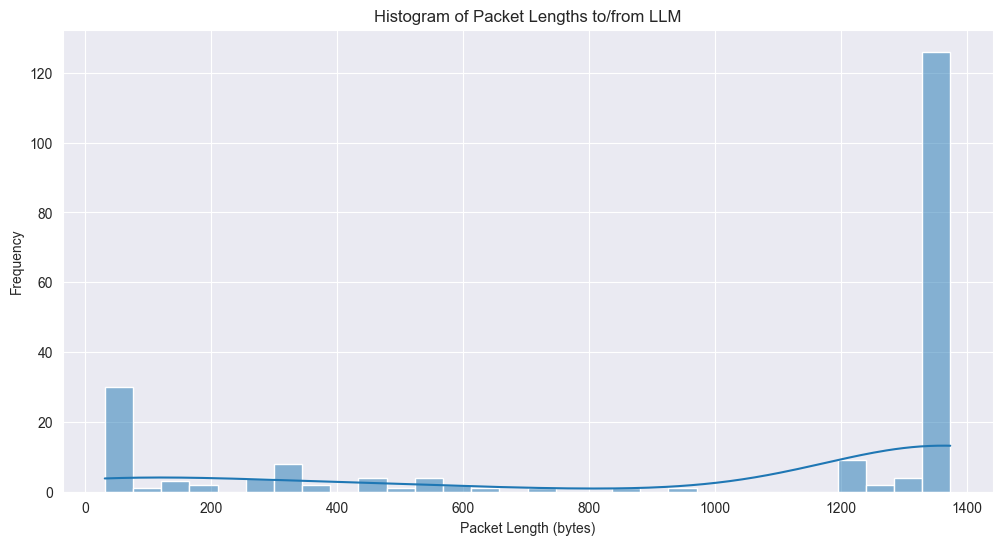

In [10]:
# histogram of packet lengths
plt.figure(figsize=(12, 6))
sns.histplot(llm_df['length'], bins=30, kde=True)
plt.title('Histogram of Packet Lengths to/from LLM')
plt.xlabel('Packet Length (bytes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

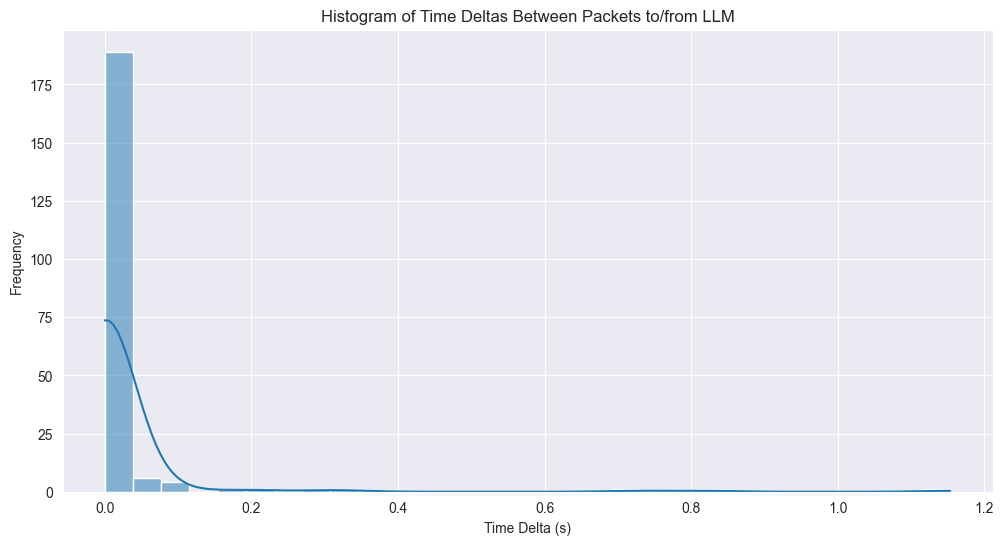

In [11]:
# histogram of time deltas
plt.figure(figsize=(12, 6))
sns.histplot(llm_df['time_delta'], bins=30, kde=True)
plt.title('Histogram of Time Deltas Between Packets to/from LLM')
plt.xlabel('Time Delta (s)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()